<h2>Fastai on covid-19 dataset</h2> 


### Step 1: Installing latest version of torch


In [4]:
!pip install "torch==1.4" "torchvision==0.5.0" #restart runtime after its done executing only if asked for.

### Step 2: Set up google colab for fast.ai

In [5]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


### Step 3: Import required libraries for image classification problem


In [6]:
from fastai.vision import *

### Step 4: Mounting Google drive

In [7]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Step 5: Setting path

In [8]:
%cd /content/gdrive/My\ Drive

/content/gdrive/My Drive


In [9]:
path=Path('Covid19-dataset/train')

In [10]:
!ls {path} #printing list of files/folder in the path

Covid  export.pkl  models  Normal  Seasonal_flu


### Step 6: Image Preprocessing 


Verifying for corrupt Images in the dataset 

In [ ]:
classes = ['Covid','Normal','Seasonal_flu'] 

In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500 )

Covid


Normal


Seasonal_flu


Dataset needs to be converted into a DataBunch object, and in the case of the computer vision data - specifically into an ImageDataBunch subclass. Parameter 1 is the path of the folder, train='.', . means the files that are present the forder are all train data with validation data of 20 percent. 

Here is the link for get_transform
https://docs.fast.ai/vision.transform.html#get_transforms

In [15]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path,train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
data.train_ds

LabelList (198 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Normal,Normal,Normal,Normal,Normal
Path: Covid19-dataset/train

In [ ]:
data.valid_ds

LabelList (49 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Normal,Normal,Seasonal_flu,Covid,Covid
Path: Covid19-dataset/train

In [ ]:
data.classes

['Covid', 'Normal', 'Seasonal_flu']

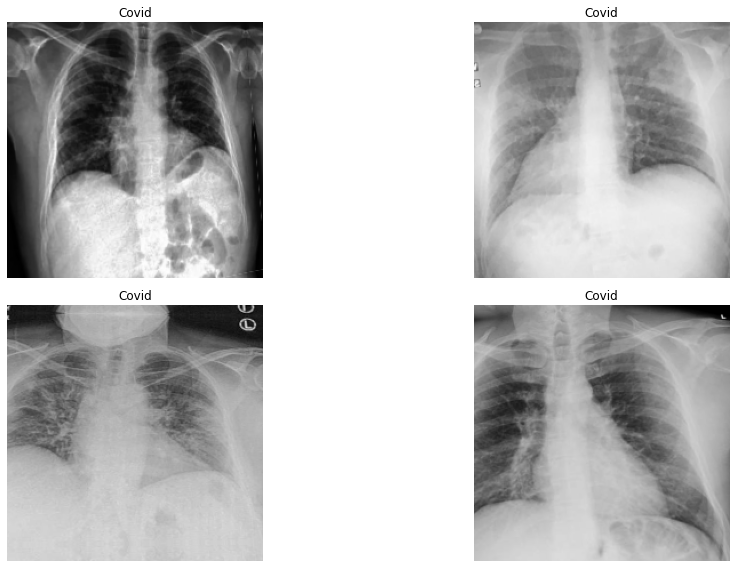

In [ ]:
data.show_batch(rows=2, figsize=(16,8))

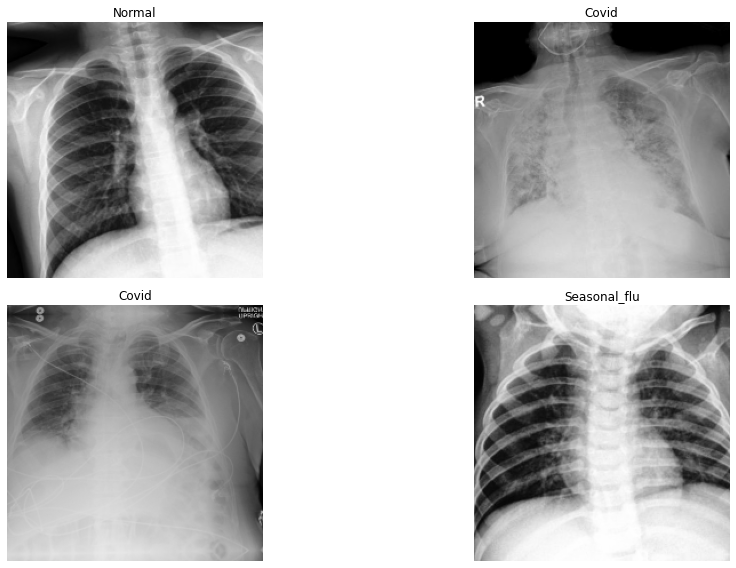

In [ ]:
data.show_batch(rows=1, figsize=(16,8))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid', 'Normal', 'Seasonal_flu'], 3, 198, 49)

### Step 7. Train model

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(10) 

epoch,train_loss,valid_loss,error_rate,time
0,1.840593,0.986210,0.530612,00:07
1,1.212819,2.421801,0.591837,00:07
2,0.942755,0.944293,0.183674,00:07
3,0.818638,0.616012,0.163265,00:07
4,0.675840,0.459265,0.163265,00:07
5,0.578275,0.304800,0.102041,00:07
6,0.512017,0.232519,0.081633,00:07
7,0.466111,0.196341,0.081633,00:07
8,0.426675,0.165737,0.061225,00:07
9,0.384657,0.151956,0.061225,00:07


In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze() #Train weights at all the layers of the network

In [ ]:
learn.lr_find() #We can either manually supply start and end learning rate or it will take values between 1e-07 to 1e01 by default

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


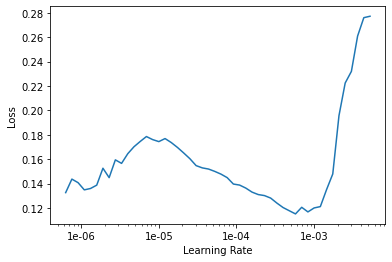

In [ ]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(20, max_lr=slice(1e-5,1e-4)) #The idea of decreasing the learning rate as you train is called learning rate annealing

epoch,train_loss,valid_loss,error_rate,time
0,0.212070,0.137819,0.061225,00:08
1,0.157784,0.155119,0.020408,00:08
2,0.137809,0.185046,0.020408,00:08
3,0.138779,0.185574,0.081633,00:08
4,0.164888,0.187037,0.040816,00:08
5,0.165708,0.175994,0.061225,00:08
6,0.157702,0.169346,0.061225,00:08
7,0.135265,0.159202,0.061225,00:08
8,0.120193,0.140376,0.061225,00:08
9,0.108072,0.121077,0.061225,00:08


In [ ]:
learn.save('stage-2')

### Step 8. Interpret the result

In [ ]:
learn.load('stage-2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

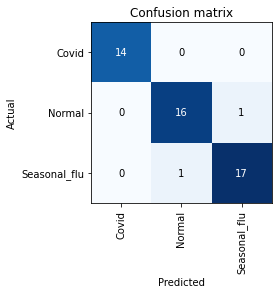

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
from fastai.widgets import *

In [ ]:
from fastai.widgets import ClassConfusion

In [ ]:
ClassConfusion(interp,classes)

Please enter a value for `k`, or the top images you will see: 3


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


<Figure size 432x288 with 0 Axes>

### Step 9. Predict a new image for the class it belongs to

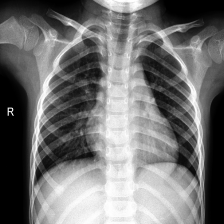

In [20]:
path=Path('Covid19-dataset/test')
img = open_image(path/'0101.jpeg')
img.resize(torch.Size([img.shape[0],224,224]))

In [ ]:
learn.export()
path=Path('Covid19-dataset/train')

learn = load_learner(path)

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'Normal'